### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
#import questionary   #Tried to include this and didn't work
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
#chaim edit 11/3/21 
from utils.writeToCSV import writeToCSV #importing to write results to CSV file
#from pathlib import Path
#import csv
%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

    



To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 5000000


In [4]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    print("Thank you for your response!  You are a conversative investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    tickers = ["FB","AAPL","TSLA","RDS.A","GS"]
    print("Thank you for your response!  You are an aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Facebook, Apple, Tesla, Shell Oil, Goldman Sachs
elif int(risk_tolerance) == 3:
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    print("Thank you for your response!  You are a very aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string



    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  3


Thank you for your response!  You are a very aggressive investor.
The stocks in your portfolio will be ['NFLX', 'ADBE', 'AMZN', 'PYPL', 'GME']


In [5]:
#Changed 2021-11-02 by Paul Lopez. We are running all time horizon scenarios to show the client the confidence intervals
# for 5, 10, and 20yrs and will output it to a CSV file if the client wants. Chaim's idea. You are welcome.

#time_horizon = input("Please select your time horizon for the forecast: 5, 10, or 20 years?")
#print(f"Thank you for your input! Your holding period will be {time_horizon} years")
#time_horizon = int(time_horizon) #forcing it to be an int
#chaim edit- changed print function to simplify output
#type if statement here if time_horizon is not 5, 10, or 20 we prompt the user to try again

In [6]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [7]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
#We can possibly make this start and end date a bit more dynamic by just pulling today's or yesterday's
#date and feeding in here as a variable.

In [8]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


ADBE                                        AMZN  \
                             open      high     low   close   volume     open   
time                                                                            
2021-10-27 00:00:00-04:00  645.37  648.8053  639.81  640.34  1348887  3389.83   

                                                               ...    NFLX  \
                           high        low     close   volume  ...    open   
time                                                           ...           
2021-10-27 00:00:00-04:00  3437  3371.4534  3393.325  2366378  ...  668.21   

                                                              PYPL            \
                             high     low   close   volume    open      high   
time                                                                           
2021-10-27 00:00:00-04:00  671.41  661.85  662.92  1899467  243.84  244.6899   

                                                     
                              low   close    volume  
time                                                 
2021-10-27 00:00:00-04:00  233.92  234.92  17726064  

[1 rows x 25 columns]

In [9]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

662.92

640.34

3393.325

234.92

173.6

In [10]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
value_per_share = portfolio_value/5 

#Paul Lopez added sample code for Bipasha to use when her dynamic weights- 20211103
#value_share1 = portfolio_value * weight1 'weight1 will be the weight as determined by Bipasha's algorithm
#value_share2 = portfolio_value * weight2
#value_share3 = portfolio_value * weight3
#value_share4 = portfolio_value * weight4
#value_share5 = portfolio_value * weight5


stock1_shares = value_per_share / stock1_close_price
stock2_shares = value_per_share / stock2_close_price
stock3_shares = value_per_share / stock3_close_price
stock4_shares = value_per_share / stock4_close_price
stock5_shares = value_per_share / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_per_share:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


With $1000000.00 you will be able to purchase 1508 shares of NFLX.
With $1000000.00 you will be able to purchase 1562 shares of ADBE.
With $1000000.00 you will be able to purchase 295 shares of AMZN.
With $1000000.00 you will be able to purchase 4257 shares of PYPL.
With $1000000.00 you will be able to purchase 5760 shares of GME.


In [11]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
start_date = pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

limit_rows = 1000

In [12]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

ADBE                                       AMZN  \
                             open     high     low   close   volume     open   
time                                                                           
2017-11-08 00:00:00-05:00  181.19  184.440  181.06  184.03  1235907  1122.23   
2017-11-09 00:00:00-05:00  182.88  183.079  179.03  181.91  2120758  1127.41   

                                                               ...    NFLX  \
                              high      low    close   volume  ...    open   
time                                                           ...           
2017-11-08 00:00:00-05:00  1135.54  1119.11  1132.86  1687417  ...  195.93   
2017-11-09 00:00:00-05:00  1129.62  1115.77  1129.00  2301337  ...  194.46   

                                                             PYPL        \
                             high     low   close   volume   open  high   
time                                                                      
2017-11-08 00:00:00-05:00  197.09  194.74  196.42  3266228  74.00  75.0   
2017-11-09 00:00:00-05:00  194.49  190.81  193.89  4052164  74.02  74.2   

                                                   
                             low   close   volume  
time                                               
2017-11-08 00:00:00-05:00  73.31  74.775  4969617  
2017-11-09 00:00:00-05:00  72.41  74.100  7248108  

[2 rows x 25 columns]

ADBE                                        AMZN  \
                             open      high     low   close   volume     open   
time                                                                            
2021-10-27 00:00:00-04:00  645.37  648.8053  639.81  640.34  1348887  3389.83   
2021-10-28 00:00:00-04:00  638.83  642.4900  633.27  639.28  1446775  3400.43   

                                                                 ...    NFLX  \
                             high        low     close   volume  ...    open   
time                                                             ...           
2021-10-27 00:00:00-04:00  3437.0  3371.4534  3393.325  2366378  ...  668.21   
2021-10-28 00:00:00-04:00  3479.0  3386.0000  3444.500  4040885  ...  671.61   

                                                              PYPL            \
                             high     low   close   volume    open      high   
time                                                                           
2021-10-27 00:00:00-04:00  671.41  661.85  662.92  1899467  243.84  244.6899   
2021-10-28 00:00:00-04:00  676.80  668.03  674.05  2550714  237.30  237.9400   

                                                     
                              low   close    volume  
time                                                 
2021-10-27 00:00:00-04:00  233.92  234.92  17726064  
2021-10-28 00:00:00-04:00  232.78  236.82  13315878  

[2 rows x 25 columns]

['NFLX', 'ADBE', 'AMZN', 'PYPL', 'GME']

###Here we run a Monte Carlo simulation of 1000 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [13]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


ADBE                                    \
                             open     high     low   close   volume   
time                                                                  
2017-11-08 00:00:00-05:00  181.19  184.440  181.06  184.03  1235907   
2017-11-09 00:00:00-05:00  182.88  183.079  179.03  181.91  2120758   
2017-11-10 00:00:00-05:00  181.00  182.060  179.83  181.73  1333612   
2017-11-13 00:00:00-05:00  180.50  182.320  179.75  181.87   921311   
2017-11-14 00:00:00-05:00  181.98  182.170  180.31  181.31  1027338   

                                           AMZN                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-08 00:00:00-05:00          NaN  1122.23  1135.54  1119.11  1132.86   
2017-11-09 00:00:00-05:00    -0.011520  1127.41  1129.62  1115.77  1129.00   
2017-11-10 00:00:00-05:00    -0.000990  1125.50  1131.75  1124.06  1125.34   
2017-11-13 00:00:00-05:00     0.000770  1123.00  1139.90  1122.34  1129.21   
2017-11-14 00:00:00-05:00    -0.003079  1130.11  1138.00  1123.89  1136.84   

                           ...     NFLX                                 PYPL  \
                           ...      low   close   volume daily_return   open   
time                       ...                                                 
2017-11-08 00:00:00-05:00  ...  194.740  196.42  3266228          NaN  74.00   
2017-11-09 00:00:00-05:00  ...  190.810  193.89  4052164    -0.012881  74.02   
2017-11-10 00:00:00-05:00  ...  189.500  191.93  5262989    -0.010109  73.77   
2017-11-13 00:00:00-05:00  ...  191.021  195.09  3286703     0.016464  73.68   
2017-11-14 00:00:00-05:00  ...  193.000  195.69  2536978     0.003076  74.10   

                                                                       
                            high    low   close   volume daily_return  
time                                                                   
2017-11-08 00:00:00-05:00  75.00  73.31  74.775  4969617          NaN  
2017-11-09 00:00:00-05:00  74.20  72.41  74.100  7248108    -0.009027  
2017-11-10 00:00:00-05:00  74.14  73.56  73.980  4225373    -0.001619  
2017-11-13 00:00:00-05:00  74.29  73.34  74.030  3728766     0.000676  
2017-11-14 00:00:00-05:00  74.82  73.62  74.490  4503222     0.006214  

[5 rows x 30 columns]

In [14]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

ADBE                                    \
                             open     high     low   close   volume   
time                                                                  
2017-11-08 00:00:00-05:00  181.19  184.440  181.06  184.03  1235907   
2017-11-09 00:00:00-05:00  182.88  183.079  179.03  181.91  2120758   
2017-11-10 00:00:00-05:00  181.00  182.060  179.83  181.73  1333612   
2017-11-13 00:00:00-05:00  180.50  182.320  179.75  181.87   921311   
2017-11-14 00:00:00-05:00  181.98  182.170  180.31  181.31  1027338   

                                           AMZN                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-08 00:00:00-05:00          NaN  1122.23  1135.54  1119.11  1132.86   
2017-11-09 00:00:00-05:00    -0.011520  1127.41  1129.62  1115.77  1129.00   
2017-11-10 00:00:00-05:00    -0.000990  1125.50  1131.75  1124.06  1125.34   
2017-11-13 00:00:00-05:00     0.000770  1123.00  1139.90  1122.34  1129.21   
2017-11-14 00:00:00-05:00    -0.003079  1130.11  1138.00  1123.89  1136.84   

                           ...     NFLX                                 PYPL  \
                           ...      low   close   volume daily_return   open   
time                       ...                                                 
2017-11-08 00:00:00-05:00  ...  194.740  196.42  3266228          NaN  74.00   
2017-11-09 00:00:00-05:00  ...  190.810  193.89  4052164    -0.012881  74.02   
2017-11-10 00:00:00-05:00  ...  189.500  191.93  5262989    -0.010109  73.77   
2017-11-13 00:00:00-05:00  ...  191.021  195.09  3286703     0.016464  73.68   
2017-11-14 00:00:00-05:00  ...  193.000  195.69  2536978     0.003076  74.10   

                                                                       
                            high    low   close   volume daily_return  
time                                                                   
2017-11-08 00:00:00-05:00  75.00  73.31  74.775  4969617          NaN  
2017-11-09 00:00:00-05:00  74.20  72.41  74.100  7248108    -0.009027  
2017-11-10 00:00:00-05:00  74.14  73.56  73.980  4225373    -0.001619  
2017-11-13 00:00:00-05:00  74.29  73.34  74.030  3728766     0.000676  
2017-11-14 00:00:00-05:00  74.82  73.62  74.490  4503222     0.006214  

[5 rows x 30 columns]

In [15]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

ADBE                                    \
                             open     high     low   close   volume   
time                                                                  
2017-11-08 00:00:00-05:00  181.19  184.440  181.06  184.03  1235907   
2017-11-09 00:00:00-05:00  182.88  183.079  179.03  181.91  2120758   
2017-11-10 00:00:00-05:00  181.00  182.060  179.83  181.73  1333612   
2017-11-13 00:00:00-05:00  180.50  182.320  179.75  181.87   921311   
2017-11-14 00:00:00-05:00  181.98  182.170  180.31  181.31  1027338   

                                           AMZN                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-08 00:00:00-05:00          NaN  1122.23  1135.54  1119.11  1132.86   
2017-11-09 00:00:00-05:00    -0.011520  1127.41  1129.62  1115.77  1129.00   
2017-11-10 00:00:00-05:00    -0.000990  1125.50  1131.75  1124.06  1125.34   
2017-11-13 00:00:00-05:00     0.000770  1123.00  1139.90  1122.34  1129.21   
2017-11-14 00:00:00-05:00    -0.003079  1130.11  1138.00  1123.89  1136.84   

                           ...     NFLX                                 PYPL  \
                           ...      low   close   volume daily_return   open   
time                       ...                                                 
2017-11-08 00:00:00-05:00  ...  194.740  196.42  3266228          NaN  74.00   
2017-11-09 00:00:00-05:00  ...  190.810  193.89  4052164    -0.012881  74.02   
2017-11-10 00:00:00-05:00  ...  189.500  191.93  5262989    -0.010109  73.77   
2017-11-13 00:00:00-05:00  ...  191.021  195.09  3286703     0.016464  73.68   
2017-11-14 00:00:00-05:00  ...  193.000  195.69  2536978     0.003076  74.10   

                                                                       
                            high    low   close   volume daily_return  
time                                                                   
2017-11-08 00:00:00-05:00  75.00  73.31  74.775  4969617          NaN  
2017-11-09 00:00:00-05:00  74.20  72.41  74.100  7248108    -0.009027  
2017-11-10 00:00:00-05:00  74.14  73.56  73.980  4225373    -0.001619  
2017-11-13 00:00:00-05:00  74.29  73.34  74.030  3728766     0.000676  
2017-11-14 00:00:00-05:00  74.82  73.62  74.490  4503222     0.006214  

[5 rows x 30 columns]

In [16]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994571,1.014098,1.010220,1.021356,0.992621,1.013312,0.971327,0.988400,0.978673,1.036219,...,0.976532,0.990194,0.992944,1.005596,0.995476,0.970125,0.979393,0.995747,1.021413,0.990998
2,1.015188,1.066843,1.040727,1.019085,0.976693,1.033676,0.959459,1.011894,0.948766,1.013268,...,0.962727,0.939586,0.991746,0.994324,1.022939,0.951069,0.940305,1.011230,1.027039,1.048876
3,1.027640,1.106390,1.074272,1.018435,0.963376,1.049116,0.982776,0.993654,0.943796,1.043802,...,1.001247,0.941597,0.991507,0.997017,1.001310,0.951911,0.919515,1.002662,0.978840,1.024086
4,1.009426,1.109817,1.088538,1.010114,0.981174,1.043206,0.975285,0.988345,0.950374,1.039056,...,1.012750,0.958996,0.984480,1.021262,1.015302,0.941394,0.943894,1.035202,1.010343,1.009037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.456141,9.885366,60.785750,12.741597,13.531215,17.697676,15.243695,34.515092,26.824942,19.482682,...,17.014848,34.218981,8.956986,22.104305,56.161579,23.419617,35.265481,24.839179,34.935568,15.518914
1257,3.520013,9.963131,61.294416,12.834391,13.678449,17.740971,14.747143,34.863604,25.962184,18.809630,...,16.755450,33.501299,8.891844,22.374969,56.294374,23.513800,34.906891,24.438042,35.423130,15.643743
1258,3.516397,9.842823,62.817934,12.814603,13.737395,18.360598,14.783232,34.903848,26.579819,18.901297,...,16.780661,34.084300,8.736950,21.644979,56.423331,24.237636,34.394938,24.021123,34.665263,16.006014
1259,3.351624,10.062908,62.281950,13.217241,14.261279,17.708892,15.200176,34.081584,28.065955,19.062147,...,16.346034,33.269282,8.282712,22.043311,54.394911,24.988992,33.897869,24.273037,35.272199,16.185604


In [17]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.020459,0.984696,1.011002,1.018634,1.014958,0.984133,1.033256,1.019939,0.954084,0.984315,...,0.965856,1.022758,1.024782,0.966890,0.996709,0.987907,0.988237,1.014049,1.003862,0.965409
2,1.007137,0.992502,1.042402,1.018625,0.980245,0.940415,1.025492,1.005196,0.967338,0.946033,...,0.980610,1.022866,0.997868,0.977197,0.995268,0.958694,1.013909,1.019322,1.018229,0.980169
3,1.024626,1.002360,1.014909,1.042682,0.994220,0.967898,1.004770,1.024384,0.991763,0.952809,...,1.003044,1.034242,0.980441,0.970189,0.991014,0.933089,1.002059,1.040000,1.002836,1.003532
4,1.061305,1.014954,0.998759,1.074576,0.976653,0.957246,1.037327,1.008288,0.985833,0.957377,...,1.031047,1.059833,0.951990,0.990112,1.003994,0.922716,0.968349,1.029625,1.057362,0.981621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,398.050548,562.836814,109.135419,689.475497,273.770637,495.013880,129.665741,139.422311,1731.362486,66.088632,...,524.778583,265.305971,353.034058,765.284502,85.826598,2181.332090,57.345024,265.302760,131.929775,42.959310
2517,388.804762,564.067003,108.968423,709.904472,267.975668,494.604925,128.262836,140.702983,1706.618269,66.515955,...,523.513354,260.518563,361.178307,751.896885,87.069631,2269.752988,54.897757,261.526292,131.420691,43.494228
2518,381.714830,589.522195,111.575546,688.444303,261.894721,517.483443,126.302673,140.351377,1640.157281,67.351324,...,519.053707,269.263691,352.469490,766.651357,85.005489,2280.419669,55.072679,254.996078,133.711829,45.285187
2519,374.354843,606.960411,109.166827,700.044726,258.438930,516.806461,126.496598,143.830569,1593.385554,67.192639,...,499.621061,265.565020,350.200865,765.891898,86.557000,2264.529887,53.927266,256.915252,134.557376,46.334902


In [18]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001656,1.011942,0.990707,1.018723,0.983932,1.002110,9.884626e-01,1.009315,9.930954e-01,0.992765,...,1.002997,1.019867,0.989641,0.988937,1.006684,1.023947,1.029197,1.011029,1.018581,1.020030
2,0.970260,1.037040,0.987901,0.974321,0.966109,0.959112,9.873218e-01,1.003197,1.042312e+00,0.983754,...,1.014259,1.052620,1.002643,0.982136,1.012857,1.041441,1.037915,1.030179,1.005056,1.010259
3,0.953454,1.069344,0.989011,1.004470,0.944003,0.968861,9.809838e-01,1.015504,1.089367e+00,0.971698,...,1.047325,1.060017,0.983687,0.960945,0.975819,1.040454,1.048080,1.020101,1.026351,1.017088
4,0.958047,1.036748,0.982125,1.015899,0.946980,1.015471,9.912862e-01,0.967290,1.068039e+00,0.987312,...,1.100493,1.057327,0.980256,0.974972,0.955614,1.024377,1.032778,1.019653,1.043637,1.002227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,43060.731241,23362.180945,67805.426153,154414.442014,8996.993456,387263.010969,1.671440e+06,89455.818273,3.712227e+06,18818.341785,...,16004.103091,47707.000667,396653.808446,152243.809346,53455.382114,424889.043184,44598.535149,31055.958161,294023.020729,257700.876929
5037,43796.655028,23506.906383,65185.393550,152326.632098,8852.840707,394018.144387,1.668744e+06,87506.090332,3.468274e+06,19260.229096,...,16151.039672,48810.068389,403829.665649,150580.726165,52784.809236,421659.253564,44324.374275,31103.715361,291717.986876,269795.801454
5038,45460.838302,23918.211958,65527.065038,153787.331198,8500.449170,409890.959928,1.665926e+06,88647.940879,3.383812e+06,19176.503009,...,16530.437175,50518.482118,416742.909192,148865.378557,54661.936696,417057.268193,45159.130085,30933.484015,292352.151811,266477.820434
5039,46918.702779,23498.055584,65777.947687,160519.871440,8513.721397,418066.095133,1.643513e+06,88870.874337,3.353152e+06,19729.869313,...,16428.381508,51386.323406,420487.993089,156568.365581,55448.466403,412949.265590,45264.563164,30743.645397,294732.116993,255598.333867


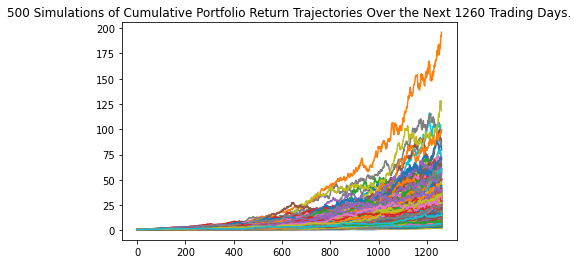

In [19]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


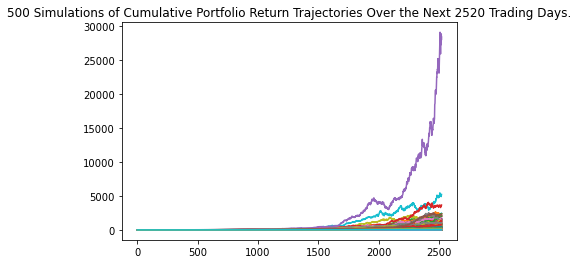

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

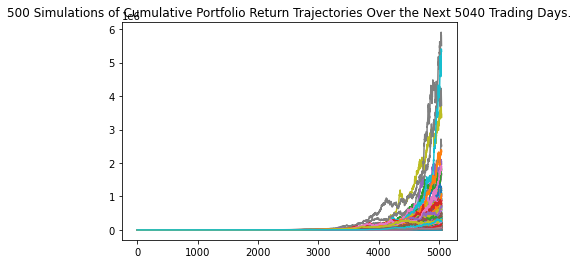

In [21]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario

MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

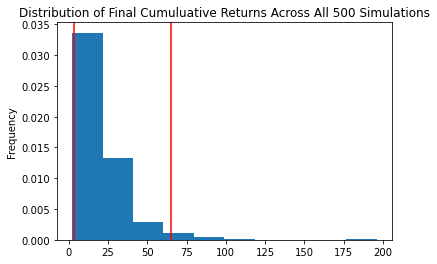

In [22]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()


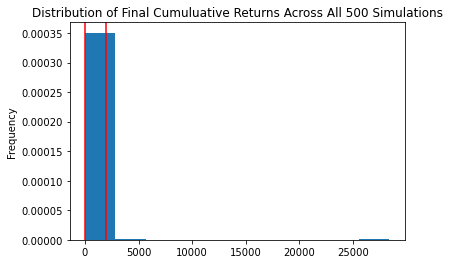

In [23]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()


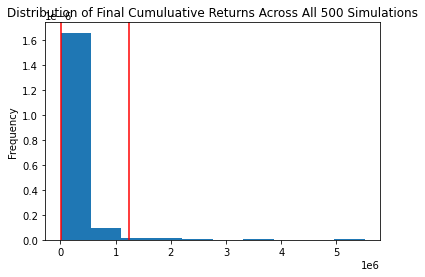

In [24]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [25]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           500.000000
mean             20.707702
std              18.033393
min               2.137519
25%               9.175100
50%              15.777739
75%              26.965100
max             195.944726
95% CI Lower      3.424878
95% CI Upper     64.851820
Name: 1260, dtype: float64


In [26]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count             500.000000
mean              463.938328
std              1350.019436
min                 6.955110
25%               116.199999
50%               248.752478
75%               480.712482
max             28368.191797
95% CI Lower       29.548011
95% CI Upper     1996.529977
Name: 2520, dtype: float64


In [27]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count           5.000000e+02
mean            2.118189e+05
std             5.062859e+05
min             1.021111e+03
25%             2.391029e+04
50%             6.125250e+04
75%             1.914934e+05
max             5.514605e+06
95% CI Lower    3.781785e+03
95% CI Upper    1.239584e+06
Name: 5040, dtype: float64


In [28]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $17124389.5 and $324259099.08.


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $147740053.94 and $9982649884.26.


In [30]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $18908926653.38 and $6197920013621.92.


In [33]:
#created dictionary to store values for csv file
client_info_dict = {
    "Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-"],
    "Value Per Share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
                         f"${value_per_share:.2f}", f"${value_per_share:.2f}"],
    "Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4]],
    "Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}", f"{stock4_shares:.0f}", f"{stock5_shares:.0f}"]    
}  
print(client_info_dict)

{'Value of Portfolio': ['$5000000.00', '-', '-', '-', '-'], 'Value Per Share': ['$1000000.00', '$1000000.00', '$1000000.00', '$1000000.00', '$1000000.00'], 'Portfolio Tickers': ['NFLX', 'ADBE', 'AMZN', 'PYPL', 'GME'], 'Shares per Ticker': ['1508', '1562', '295', '4257', '5760']}


In [34]:
#created dataframe from dictionary
client_info_df = pd.DataFrame(client_info_dict)
client_info_df.set_index("Value of Portfolio")

,Value Per Share,Portfolio Tickers,Shares per Ticker
Value of Portfolio,,,
$5000000.00,$1000000.00,NFLX,1508
-,$1000000.00,ADBE,1562
-,$1000000.00,AMZN,295
-,$1000000.00,PYPL,4257
-,$1000000.00,GME,5760


In [ ]:
#created csv with dataframe
#client_info_df.to_csv("Client Info.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [35]:
#created dictionary to turn into a csv file
report_details_dict = {
    "Holding Period" : ["5year", "10year", "20year"],
    "Lower Bound Values" : [f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
                   f"${ci_lower_thirty_cumulative_return_20yr}"],
    "Upper Bound Values" : [f"${ci_upper_thirty_cumulative_return_5yr}",f"${ci_upper_thirty_cumulative_return_10yr}",
                   F"${ci_upper_thirty_cumulative_return_20yr}"]}
                 

In [36]:
#created dataframe with dictionary
report_details_df = pd.DataFrame(report_details_dict)
report_details_df.set_index("Holding Period")

,Lower Bound Values,Upper Bound Values
Holding Period,,
5year,$17124389.5,$324259099.08
10year,$147740053.94,$9982649884.26
20year,$18908926653.38,$6197920013621.92


In [ ]:
# created csv file with dataframe
#report_details_df.to_csv("Report Details.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [37]:
writeToCSV("Client_Info.csv", "Report_Details.csv",client_info_df, report_details_df)
#writeToCSV("FinalReport.csv",combinedDataFrame) #for Chaim

Reports have been saved. Have a nice day!
